# Setup

In [2]:
# Packages -----------------------------------------------#

# Data Analysis
import xarray as xr
import numpy as np
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.dates as dates
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Timing Processes and Progress
import time
from tqdm import tqdm

# make sure the figures plot inline rather than at the end
%matplotlib inline

# get data
path = '/home/jennap/projects/LRGROUP/shared_data/sst_OISSTmonthly/'
infn = 'allsst.avhrr-only-v2.1981_2018_monthly.nc'

ds = xr.open_dataset(path + infn)
ds


<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 720, lon: 1440, time: 445)
Coordinates:
  * lon        (lon) float32 0.125 0.375 0.625 0.875 ... 359.375 359.625 359.875
  * lat        (lat) float32 -89.875 -89.625 -89.375 ... 89.375 89.625 89.875
  * time       (time) datetime64[ns] 1981-09-15T12:00:00 ... 2018-09-15T12:00:00
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] ...
    sst        (time, lat, lon) float32 ...
Attributes:
    CDI:                       Climate Data Interface version 1.8.2 (http://m...
    Conventions:               CF-1.6
    history:                   Thu Mar 28 17:31:58 2019: cdo monmean allsst.a...
    NCO:                       "4.5.4"
    nco_openmp_thread_number:  1
    frequency:                 mon
    CDO:                       Climate Data Operators version 1.8.2 (http://m...

In [3]:
# Subset ------------------------------------------------#
# Create slice variables to subset domain before finding means
lat_slice = slice(-20, 30) # bounds inclusive
lon_slice = slice(35, 120) # bounds inclusive

# Get data, selecting lat/lon slice
mon_sst = ds['sst'].sel(lat=lat_slice,lon=lon_slice)
lat = mon_sst.lat.values
lon = mon_sst.lon.values
mon_sst

<xarray.DataArray 'sst' (time: 445, lat: 200, lon: 340)>
[30260000 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 35.125 35.375 35.625 ... 119.375 119.625 119.875
  * lat      (lat) float32 -19.875 -19.625 -19.375 ... 29.375 29.625 29.875
  * time     (time) datetime64[ns] 1981-09-15T12:00:00 ... 2018-09-15T12:00:00
Attributes:
    long_name:  Daily sea surface temperature
    units:      degrees C

# 1993-2012 anomaly

In [4]:
time_slice = slice('1993-01-01','2012-12-31')
mean_mon_sst = mon_sst.sel(lat=lat_slice,lon=lon_slice, time = time_slice).mean(axis=0,skipna=True)
mon_ssta = mon_sst - np. nanmean(mean_mon_sst,0)
mon_ssta

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (time: 445, lat: 200, lon: 340)>
array([[[-3.125532, -3.277723, ..., -3.018707, -3.005703],
        [      nan, -3.145723, ..., -2.777374, -2.762371],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-1.163843, -1.516088, ..., -1.59132 , -1.39266 ],
        [      nan, -1.405443, ..., -1.464546, -1.262661],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       ...,

       [[-1.945135, -2.184477, ..., -6.888741, -6.78137 ],
        [      nan, -2.090282, ..., -6.115837, -6.060402],
        ...,
        [      nan,       nan, ...,       nan,       nan],
        [      nan,       nan, ...,       nan,       nan]],

       [[-0.685532, -1.05839 , ..., -5.110041, -5.163036],
        [      nan, -1.059723, ..., -4.860041, -4.879036],
        ...,
        [      nan,       nan, ...,       nan,

# Detrend

In [6]:
%%time

# stack lat and lon into a single dimension called allpoints
stacked = mon_sst.stack(allpoints=['lat','lon'])
# set places where there are nans to zero since polyfit can't deal with them
stacked_nonan = stacked.fillna(0)

# convert date to a number to polyfit can handle it
datenum = dates.date2num(stacked_nonan.time)
mon_ssta_slope, mon_ssta_intercept = np.polyfit(datenum, stacked_nonan, 1)

#reshape the data
mon_ssta_slope = np.reshape(mon_ssta_slope, mon_ssta.shape[1:3])
mon_ssta_intercept = np.reshape(mon_ssta_intercept, mon_ssta.shape[1:3])

# define a function to compute a linear trend of a timeseries
def linear_detrend(y):
    x = dates.date2num(y.time)
    m, b = np.polyfit(x, y, 1)
    # we need to return a dataarray or else xarray's groupby won't be happy
    return xr.DataArray(y - (m*x + b))

# apply the function over allpoints to calculate the trend at each point
mon_ssta_dtrnd = stacked_nonan.groupby('allpoints').apply(linear_detrend)
# unstack back to lat lon coordinates
mon_ssta_dtrnd = mon_ssta_dtrnd.unstack('allpoints')

# fill all points we set originally to zero back to nan
mon_ssta_dtrnd = mon_ssta_dtrnd.where(~np.isnan(mon_ssta))

CPU times: user 1h 4min 41s, sys: 2min 32s, total: 1h 7min 13s
Wall time: 2min 40s


/home/jennap/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


<function matplotlib.pyplot.legend(*args, **kwargs)>

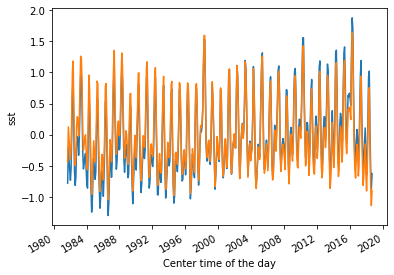

In [7]:
# find global means for comparison
stacked = mon_ssta.stack(allpoints=['lat','lon'])
global_mean = stacked.mean(dim='allpoints',skipna=True)
global_mean.plot()

# find global means for comparison
stacked = mon_ssta_dtrnd.stack(allpoints=['lat','lon'])
global_mean_dtrnd = stacked.mean(dim='allpoints',skipna=True)
global_mean_dtrnd.plot()
plt.legend

# Downsample to Monthly and Seasonal Temporal Resolution

In [14]:
%%time
# monthly
# mon_chla_dtrnd = daily_chla_dtrnd.resample(time='1MS').mean(dim="time")
# seasonal
seas_ssta_dtrnd = mon_ssta_dtrnd.resample(time='QS-DEC').mean(dim="time")

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 802 ms, sys: 54.8 ms, total: 857 ms
Wall time: 745 ms


# Find Climatologies 
Resources: [link](http://xarray.pydata.org/en/stable/examples/monthly-means.html)

In [15]:
%%time
# -------------------------------------------
# weighted seasonal
# -------------------------------------------

# get months
month_length = mon_ssta_dtrnd.time.dt.days_in_month

# calculate the weights by grouping by 'time.season'.
weights = month_length.groupby('time.season') / month_length.groupby('time.season').sum()

# calculate the weighted average
ssta_seas_clim = (mon_ssta_dtrnd * weights).groupby('time.season').sum(dim='time')   

# set the places that are now zero from the weights to nans
ssta_seas_clim = ssta_seas_clim.where(ssta_seas_clim != 0,np.nan) # for some reason .where sets the locations not in the condition to nan by default

# -------------------------------------------
# monthly
# -------------------------------------------

ssta_mon_clim = mon_ssta_dtrnd.groupby('time.month').mean('time') 

/home/jennap/anaconda3/lib/python3.7/site-packages/xarray/core/nanops.py:161: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


CPU times: user 10 s, sys: 417 ms, total: 10.5 s
Wall time: 616 ms


# Find Anomalies

In [17]:
%%time
# monthly avg data - monthly climatology
mon_ssta_mon_anom = mon_ssta_dtrnd.groupby('time.month') - ssta_mon_clim

# seasonal avg data - seasonal climatology
seas_ssta_seas_anom = seas_ssta_dtrnd.groupby('time.season') - ssta_seas_clim

CPU times: user 7.84 s, sys: 691 ms, total: 8.53 s
Wall time: 383 ms


In [19]:
# convert to xarray dataset
ds=xr.Dataset(coords={'lon': mon_ssta_dtrnd.lon,
                    'lat': mon_ssta_dtrnd.lat,
                    'time': mon_ssta_dtrnd.time})

# add variables to dataset

ds["mon_ssta"]=xr.DataArray(mon_ssta_dtrnd,dims = ['time','lat', 'lon'],
                     coords =[mon_ssta_dtrnd.time,mon_ssta_dtrnd.lat,mon_ssta_dtrnd.lon])
ds["seas_ssta"]=xr.DataArray(seas_ssta_dtrnd,dims = ['season_time','lat', 'lon'],
                     coords =[seas_ssta_dtrnd.time,mon_ssta_dtrnd.lat,mon_ssta_dtrnd.lon])

# clim
ds["ssta_mon_clim"]=xr.DataArray(ssta_mon_clim,dims = ['month','lat', 'lon'],
                     coords =[ssta_mon_clim.month,mon_ssta_dtrnd.lat,mon_ssta_dtrnd.lon])
ds["ssta_seas_clim"]=xr.DataArray(ssta_seas_clim,dims = ['season','lat', 'lon'],
                     coords =[ssta_seas_clim.season,mon_ssta_dtrnd.lat,mon_ssta_dtrnd.lon])


# anom
ds["mon_ssta_mon_anom"]=xr.DataArray(mon_ssta_mon_anom,dims = ['time','lat', 'lon'],
                     coords =[mon_ssta_mon_anom.time,mon_ssta_dtrnd.lat,mon_ssta_dtrnd.lon])
ds["seas_ssta_seas_anom"]=xr.DataArray(seas_ssta_seas_anom,dims = ['season_time','lat', 'lon'],
                     coords =[seas_ssta_seas_anom.time,mon_ssta_dtrnd.lat,mon_ssta_dtrnd.lon])


In [20]:
import os

outfn = 'sst_processed.nc'

# delete if already present
if os.path.isfile(outfn):
    os.remove(outfn)

ds.to_netcdf(outfn,mode='w',format = "NETCDF4")

ds

<xarray.Dataset>
Dimensions:              (lat: 200, lon: 340, month: 12, season: 4, season_time: 149, time: 445)
Coordinates:
  * lon                  (lon) float64 35.12 35.38 35.62 ... 119.4 119.6 119.9
  * lat                  (lat) float64 -19.88 -19.62 -19.38 ... 29.62 29.88
  * time                 (time) datetime64[ns] 1981-09-15T12:00:00 ... 2018-09-15T12:00:00
  * season_time          (season_time) datetime64[ns] 1981-09-01 ... 2018-09-01
  * month                (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * season               (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    mon_ssta             (time, lat, lon) float64 -3.523 -3.414 ... nan nan
    seas_ssta            (season_time, lat, lon) float64 -1.536 -1.587 ... nan
    ssta_mon_clim        (month, lat, lon) float64 2.608 2.434 2.263 ... nan nan
    ssta_seas_clim       (season, lat, lon) float64 2.416 2.247 ... nan nan
    mon_ssta_mon_anom    (time, lat, lon) float64 -1.392 -1.234 ... nan nan
    seas_sst